In [2]:
import pandas as pd

# Charger les données brutes
df = pd.read_csv("Electric_Vehicle_Population_Data.csv")

df.head()
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150482 entries, 0 to 150481
Data columns (total 17 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   VIN (1-10)                                         150482 non-null  object 
 1   County                                             150479 non-null  object 
 2   City                                               150479 non-null  object 
 3   State                                              150482 non-null  object 
 4   Postal Code                                        150479 non-null  float64
 5   Model Year                                         150482 non-null  int64  
 6   Make                                               150482 non-null  object 
 7   Model                                              150482 non-null  object 
 8   Electric Vehicle Type                              150482 non-null  object

In [3]:
df_clean = df.dropna(subset=["Model Year"])  # retire lignes sans année

df_clean["Model Year"] = df_clean["Model Year"].astype(int)


In [4]:
df_year = df_clean.groupby("Model Year")["VIN (1-10)"].count().reset_index()
df_year.columns = ["ds", "y"]  # Prophet impose ds/y
df_year["ds"] = pd.to_datetime(df_year["ds"], format="%Y")

df_year


,ds,y
0,1997-01-01,1
1,1998-01-01,1
2,1999-01-01,4
3,2000-01-01,8
4,2002-01-01,2
5,2003-01-01,1
6,2008-01-01,19
7,2010-01-01,24
8,2011-01-01,796
9,2012-01-01,1633


In [5]:
from prophet import Prophet

model = Prophet(
    yearly_seasonality=False,
    changepoint_prior_scale=0.3
)

model.fit(df_year)

future = model.make_future_dataframe(periods=6, freq='Y')
forecast = model.predict(future)


19:39:13 - cmdstanpy - INFO - Chain [1] start processing
19:39:13 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\log\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


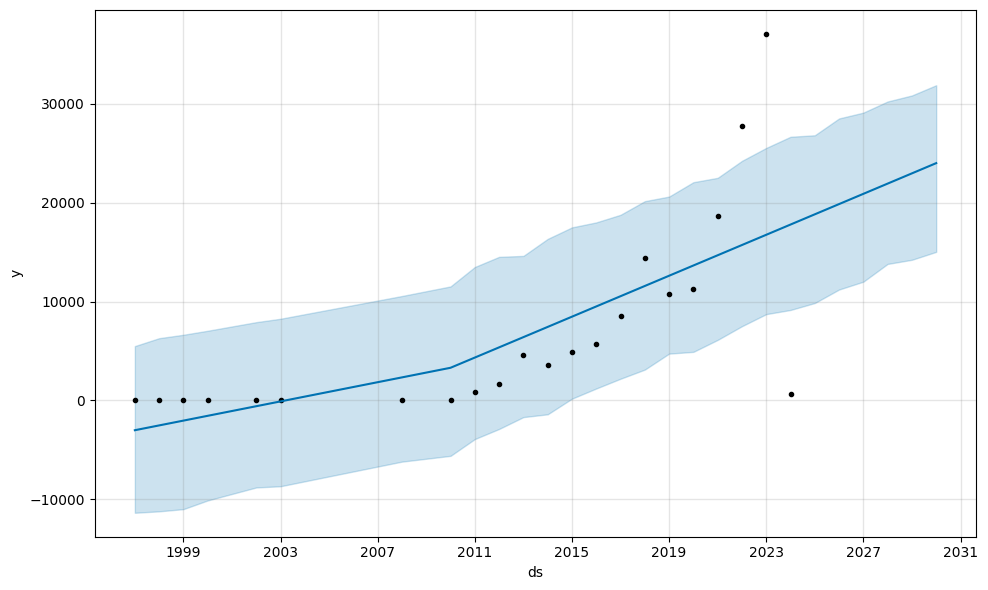

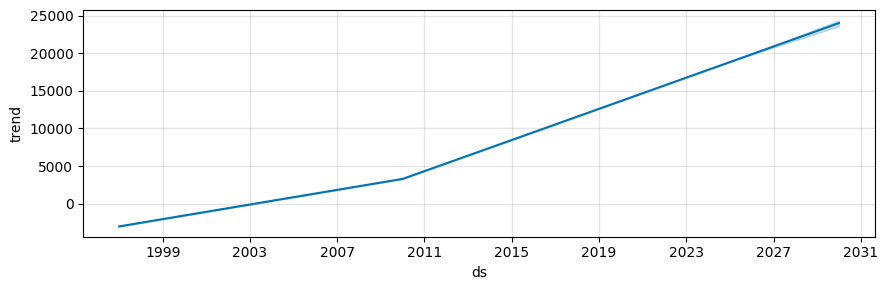

In [6]:
model.plot(forecast)
model.plot_components(forecast)

# Export pour Power BI
forecast_export = forecast[["ds","yhat"]]
forecast_export.columns = ["Year", "Forecast_Total_Vehicles"]

forecast_export.to_csv("Forecast_EV_US_2030.csv", index=False)


In [9]:
import pandas as pd
from prophet import Prophet

df = pd.read_csv("Electric_Vehicle_Population_Data.csv")

# Nettoyage + agrégation
df = df.dropna(subset=["Model Year"])
df["Model Year"] = df["Model Year"].astype(int)
df = df[df["Model Year"] >= 2011]  # Ne garder que années EV réalistes

df_year = df.groupby("Model Year")["VIN (1-10)"].count().reset_index()
df_year.columns = ["ds", "y"]
df_year["ds"] = pd.to_datetime(df_year["ds"], format="%Y")

# Prophet Model — empêcher négatifs
model = Prophet(growth="logistic")
df_year["cap"] = df_year["y"].max() * 3   # plafond de croissance logique

model.fit(df_year)

future = model.make_future_dataframe(periods=6, freq="Y")
future["cap"] = df_year["y"].max() * 3

forecast = model.predict(future)

# Export propre
forecast_final = forecast[["ds","yhat"]]
forecast_final = forecast_final[forecast_final["ds"].dt.year <= 2030]

forecast_final.columns = ["Year", "Forecast_Total_Vehicles"]
forecast_final["Year"] = forecast_final["Year"].dt.year

forecast_final.to_csv("Forecast_EV_US_2011_2030.csv", index=False)

forecast_final


23:22:39 - cmdstanpy - INFO - Chain [1] start processing
23:22:39 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\log\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


,Year,Forecast_Total_Vehicles
0,2011,-1090.257172
1,2012,-2039.690649
2,2013,7008.204022
3,2014,6446.500703
4,2015,5711.173480
5,2016,4801.948770
6,2017,13877.294681
7,2018,13329.927402
8,2019,12595.804700
9,2020,11674.643821


In [11]:
import pandas as pd

df = pd.read_csv("Forecast_EV_US_2011_2030.csv")

# 1️ Remplacer valeurs négatives par 0
df["Forecast_Total_Vehicles"] = df["Forecast_Total_Vehicles"].clip(lower=0)

# 2️ Garder seulement la dernière année unique
df = df.drop_duplicates(subset="Year", keep="last")

# 3️ Trier correctement
df = df.sort_values("Year")

# 4️ Lissage optionnel : Moving Average
df["Forecast_Total_Vehicles"] = df["Forecast_Total_Vehicles"].rolling(3, min_periods=1).mean()

df.to_csv("Forecast_Clean.csv", index=False)

df


,Year,Forecast_Total_Vehicles
0,2011,0.000000
1,2012,0.000000
2,2013,2336.068007
3,2014,4484.901575
4,2015,6388.626068
5,2016,5653.207651
6,2017,8130.138977
7,2018,10669.723618
8,2019,13267.675594
9,2020,12533.458641
